In [1]:
import c3s
import math
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
import seaborn as sns
from scipy.sparse.linalg import expm
import tikzplotlib

In [23]:
def H(X, base=math.e):
    '''shannon entropy'''
    
    entropy = 0
    for p_x in X:
        if p_x == 0:
            continue
        entropy += p_x * math.log(1/p_x, base)
    
    return entropy

In [ ]:
def plot_mi_with_species(data, species, title=None):
    
    n_timesteps = len(data[1][-1])
    x_values = np.linspace(1, n_timesteps, n_timesteps) - 1
    n_rate_types = len(rates) 
    
    plt.style.use('bmh')
    lines = ["-","--","-.",":"]
    markers = ['o','s','x', 'v']

    fig, axes = plt.subplots(nrows=2*len(rates), ncols=2, sharex=True, sharey=True, figsize=(16,10))
    twin_axes = [ax.twinx() for ax in axes.reshape(-1)]
    for twin_ax in twin_axes[1:]:
        twin_axes[0].get_shared_y_axes().join(twin_axes[0], twin_ax)

    mi_max = 0
    barriers = [i*4 for i in range(n_rate_types + 1)]
    for i in range(n_rate_types):
        for ax, twin_ax, rate in zip(axes.reshape(-1)[barriers[i]:barriers[i+1]], twin_axes, [1, 2, 4, 10]):
            linecycler = cycle(lines)
            markercycler = cycle(markers)
            for i, molecule in enumerate(species):
                twin_ax.plot(x_values, mut_inf_dict[rate][i], color='red',
                             alpha=0.6, label=fr'<$c^{{{molecule}}}$>',
                             linestyle=next(linecycler),
                             marker=next(markercycler), markevery=20,
                             markersize=9)
            ax.plot(x_values, mut_inf_dict[rate][-1], color='blue', linewidth=3)
            ax.set_title(f'K = {rate}', fontsize=22)
            ax.yaxis.set_tick_params(labelsize=18, labelcolor='blue')
            ax.xaxis.set_tick_params(labelsize=18)
            twin_ax.yaxis.set_tick_params(labelsize=18, labelcolor='red')
            if np.max(mut_inf_dict[rate][-1]) > mi_max:
                ax.set_ylim(-0.01, np.max(mut_inf_dict[rate][-1]) + 0.05)
                mi_max = np.max(mut_inf_dict[rate][-1])
        

    twin_axes[2].yaxis.set_tick_params(labelright=False)
    twin_axes[0].yaxis.set_tick_params(labelright=False)
    axes[0,0].set_ylabel('mutual information (bits)', fontsize=18, labelpad=7)
    axes[1,0].set_ylabel('mutual information (bits)', fontsize=18, labelpad=7)
    axes[1,0].set_xlabel(r'timestep $(\Delta t = 0.01)$', fontsize=18)
    axes[1,1].set_xlabel(r'timestep $(\Delta t = 0.01)$', fontsize=18)
    twin_axes[1].set_ylabel('average population', fontsize=18, labelpad=7)
    twin_axes[3].set_ylabel('average population', fontsize=18, labelpad=7)
    twin_axes[0].legend(loc='lower right', fontsize=20, ncol=2)

    sns.despine(bottom=False, left=False, right=False)
    plt.tight_layout()
    if title:
        plt.savefig(f'{title}.pdf')

In [161]:
a = np.arange(8)
a

array([0, 1, 2, 3, 4, 5, 6, 7])

In [163]:
a[0:4]

array([0, 1, 2, 3])

In [168]:
a[4:8]


array([4, 5, 6, 7])

## Binary 2 state

In [24]:
def binary_MI(P, base=math.e):
    return H(P, base=base)

In [25]:
G = np.array([[-1, 1], # generator matrix
              [ 1,-1]])
dt = 0.01
Q = expm(G*dt) # propagator

start, stop = 0, 1
n_timesteps = int(np.round((stop - start) / dt))
P_t = np.empty(shape=(n_timesteps, 2), dtype=np.float64)
# set intial state to (1, 0)
P_t[0] = np.array([1,0])
# apply propagator n_timesteps-1 times
for ts in range(n_timesteps-1):
    P_t[ts+1] = Q.dot(P_t[ts])

In [26]:
mut_inf = np.array([binary_MI(P, base=2) for P in P_t])
mut_inf[0::10]

array([0.        , 0.43858457, 0.6457636 , 0.77025155, 0.84901701,
       0.90004559, 0.93353366, 0.95567906, 0.9703932 , 0.98019935])

In [27]:
binary = c3s.simulators.MasterEquation(A=1, cfg='config_files/binary.yml')
binary_mutual_infs = {}

rank 0 working on generator matrix.:   0%|          | 0/2 [00:00<?, ?it/s]

In [28]:
for rate in [1, 2, 4, 10]:
    binary.reset_rates()
    binary.update_rates(k_1=rate)
    binary.run(0, 3, 0.01)
    binary_mutual_infs[rate] = [binary.calculate_average_population('A'),
                                binary.calculate_average_population('B'),
                                binary.calculate_mutual_information('A', 'B', base=2)]

rank 0 running.:   0%|          | 0/299 [00:00<?, ?it/s]

rank 0 calculating mutual information.:   0%|          | 0/300 [00:00<?, ?it/s]

rank 0 running.:   0%|          | 0/299 [00:00<?, ?it/s]

rank 0 calculating mutual information.:   0%|          | 0/300 [00:00<?, ?it/s]

rank 0 running.:   0%|          | 0/299 [00:00<?, ?it/s]

rank 0 calculating mutual information.:   0%|          | 0/300 [00:00<?, ?it/s]

rank 0 running.:   0%|          | 0/299 [00:00<?, ?it/s]

rank 0 calculating mutual information.:   0%|          | 0/300 [00:00<?, ?it/s]

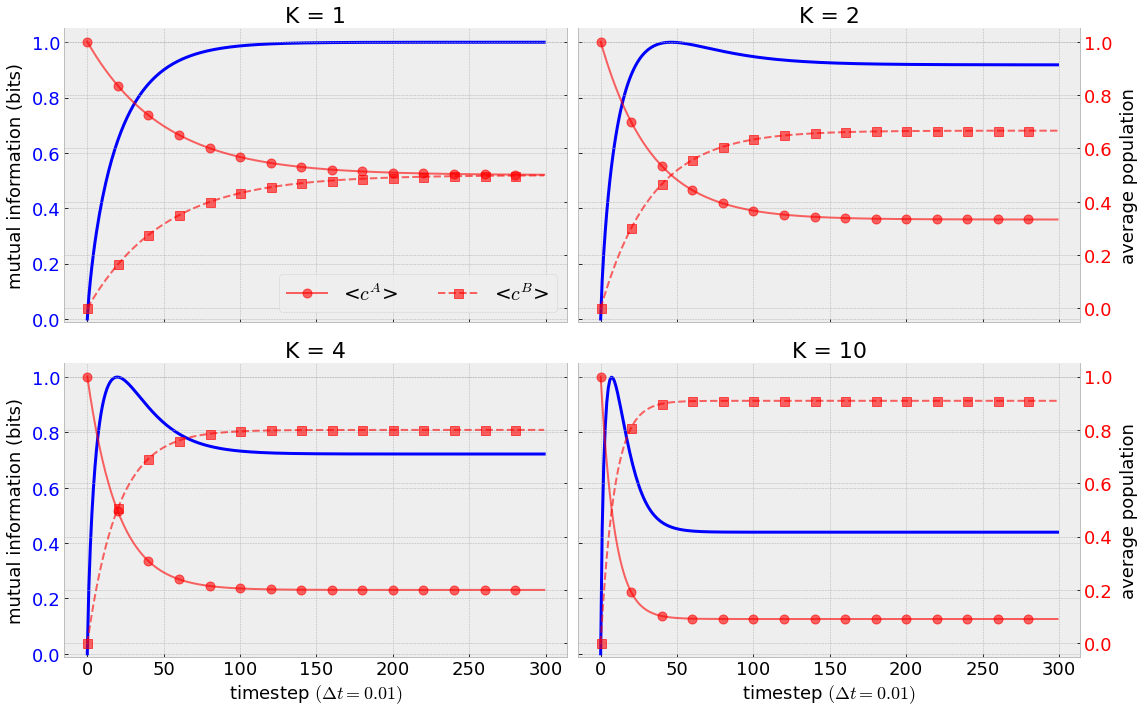

In [158]:
plot_mi_with_species(binary_mutual_infs, ['A', 'B'], title='binary')

## Binary 2 state many body

In [121]:
G = np.array([[-3, 1, 0, 0],
              [ 3,-3, 2, 0],
              [ 0, 2,-3, 3],
              [ 0, 0, 1,-3]])
dt = 0.01
Q = expm(G*dt)
start, stop = 0, 2
n_timesteps = int(np.round((stop - start) / dt))
P_t = np.empty(shape=(n_timesteps, len(G)), dtype=np.float64)
# set intial state 
P_t[0] = np.array([1,0,0,0])
# apply propagator n_timesteps-1 times
for ts in range(n_timesteps-1):
    P_t[ts+1] = Q.dot(P_t[ts])

In [122]:
mut_inf2 = np.array([binary_MI(P, base=2) for P in P_t])
mut_inf2[0::10]

array([0.        , 0.92385593, 1.28269609, 1.48006893, 1.59832796,
       1.67229091, 1.71971752, 1.75060155, 1.77091263, 1.78435647,
       1.79329262, 1.79924915, 1.80322697, 1.8058867 , 1.80766658,
       1.80885833, 1.80965658, 1.81019139, 1.81054976, 1.81078993])

In [123]:
manybodybinary = c3s.simulators.MasterEquation(cfg='config_files/binary.yml', A=3)
binary3_mut_infs = {}

rank 0 working on generator matrix.:   0%|          | 0/4 [00:00<?, ?it/s]

In [124]:
for rate in [1, 2, 4, 10]:
    manybodybinary.reset_rates()
    manybodybinary.update_rates(k_1=rate)
    manybodybinary.run(0, 3, 0.01)
    binary3_mut_infs[rate] = [manybodybinary.calculate_average_population('A'),
                              manybodybinary.calculate_average_population('B'),
                              manybodybinary.calculate_mutual_information('A', 'B', base=2)]

rank 0 running.:   0%|          | 0/299 [00:00<?, ?it/s]

rank 0 calculating mutual information.:   0%|          | 0/300 [00:00<?, ?it/s]

rank 0 running.:   0%|          | 0/299 [00:00<?, ?it/s]

rank 0 calculating mutual information.:   0%|          | 0/300 [00:00<?, ?it/s]

rank 0 running.:   0%|          | 0/299 [00:00<?, ?it/s]

rank 0 calculating mutual information.:   0%|          | 0/300 [00:00<?, ?it/s]

rank 0 running.:   0%|          | 0/299 [00:00<?, ?it/s]

rank 0 calculating mutual information.:   0%|          | 0/300 [00:00<?, ?it/s]

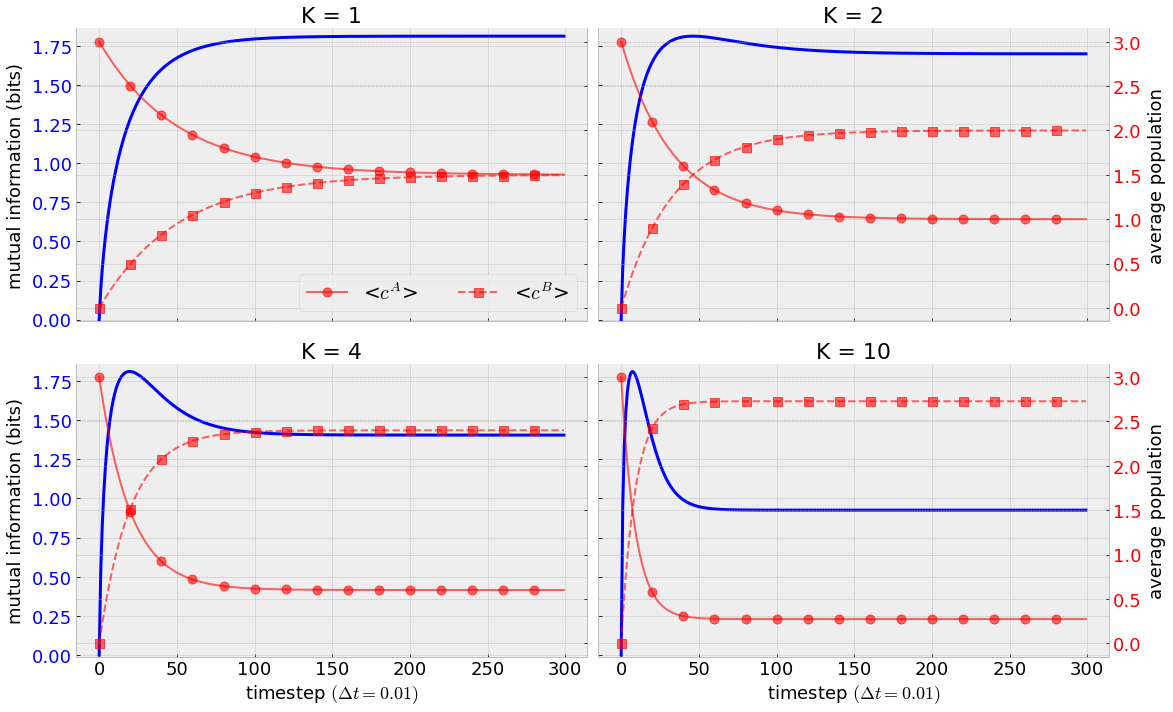

In [125]:
plot_mi_with_species(binary3_mut_infs, ['A', 'B'], title='manybodybinary')

## 2 Isolated switches

In [126]:
G = np.array([[-2, 1, 1, 0],
              [ 1,-2, 0, 1],
              [ 1, 0,-2, 1],
              [ 0, 1, 1,-2]])
dt = 0.01
Q = expm(G*dt)
start, stop = 0, 1
n_timesteps = int(np.round((stop - start) / dt))
P_t = np.empty(shape=(n_timesteps, len(G)), dtype=np.float64)
# set intial state 
P_t[0] = np.array([1,0,0,0])
# apply propagator n_timesteps-1 times
for ts in range(n_timesteps-1):
    P_t[ts+1] = Q.dot(P_t[ts])

In [127]:
def MI_2switch(P, base=2):
    
    p1, p2, p3, p4 = P
    term1 = p1*math.log( p1 / ((p1+p3)*(p1+p2)), base) if p1 !=0 else 0
    term2 = p2*math.log( p2 / ((p2+p4)*(p1+p2)), base) if p2 !=0 else 0
    term3 = p3*math.log( p3 / ((p1+p3)*(p3+p4)), base) if p3 !=0 else 0
    term4 = p4*math.log( p4 / ((p2+p4)*(p3+p4)), base) if p4 !=0 else 0
    
    return term1 + term2 + term3 + term4

In [128]:
def mut_inf(P, base=2):
    P = P / np.sum(P)
    
    p1 = P[0]
    p2 = P[1]
    p3 = P[2]
    p4 = P[3]
    term1 = p1*math.log( p1 / ((p1+p3)*(p1+p2)), base) if p1 !=0 else 0
    term2 = p2*math.log( p2 / ((p2+p4)*(p1+p2)), base) if p2 !=0 else 0
    term3 = p3*math.log( p3 / ((p1+p3)*(p3+p4)), base) if p3 !=0 else 0
    term4 = p4*math.log( p4 / ((p2+p4)*(p3+p4)), base) if p4 !=0 else 0
    
    return term1 + term2 + term3 + term4

In [129]:
p1 = [1, 2, 10]
p2 = [1, 2, 10]
p3 = [1, 2, 10]
p4 = [1, 2, 10]

In [130]:
mut_infs = np.empty(shape=(3,3,3,3))
for i in range(3):
    for j in range(3):
        for k in range(3):
            for l in range(3):
                P = np.array([p1[i], p2[j], p3[k], p4[l]])
                mut_infs[i,j,k,l] = mut_inf(P)

In [131]:
labels = []
vectorized = []
for i in range(3):
    for j in range(3):
        for k in range(3):
            for l in range(3):
                labels.append(f'({p1[i]},{p2[j]},{p3[k]},{p4[l]})')
                vectorized.append(mut_infs[i,j,k,l])

In [132]:
idx = np.asarray([i for i in range(len(vectorized))])
xticklabels = []
for i in range(len(vectorized)):
    if vectorized[i] == 0:
        xticklabels.append(labels[i])
    elif vectorized[i] > 0.5:
        xticklabels.append(labels[i])
    else:
        xticklabels.append('')

/tmp/ipykernel_77646/3803936511.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels, rotation=70, fontsize=13)


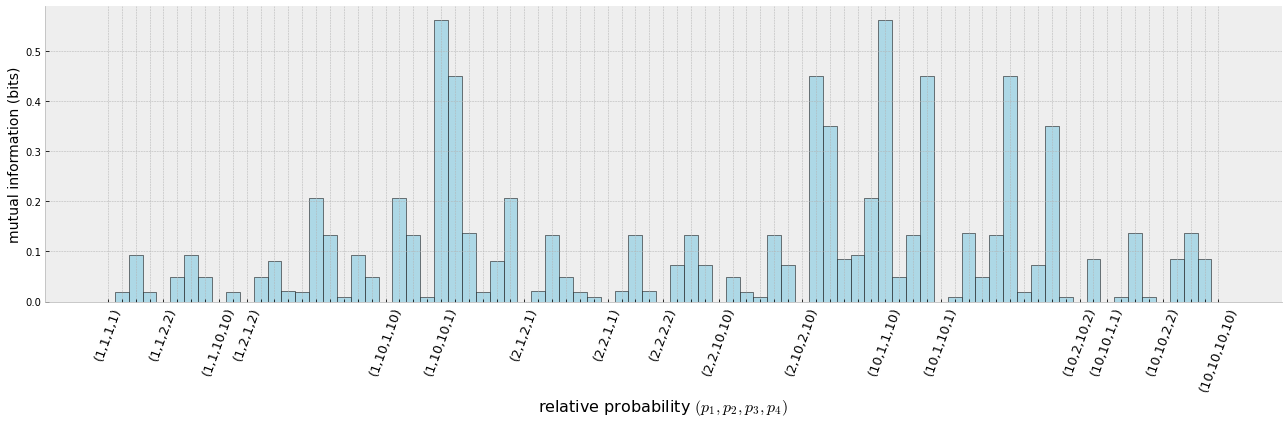

In [133]:
fig, ax = plt.subplots(figsize=(18,6))
sns.despine()
ax.bar(labels, vectorized, width=1,edgecolor='black', color='lightblue')
ax.set_ylabel('mutual information (bits)', fontsize=14)
ax.set_xticklabels(xticklabels, rotation=70, fontsize=13)
plt.xlabel(r'relative probability $(p_1, p_2, p_3, p_4)$', fontsize=16)
plt.tight_layout()
tikzplotlib.save('2switch_mi.pgf')
plt.savefig('2switch_mi.pdf')

In [134]:
iso_switches = c3s.simulators.MasterEquation(A=1, B=1, cfg='config_files/2_isolated_switches.yml')
iso_switches_dict = {}

rank 0 working on generator matrix.:   0%|          | 0/4 [00:00<?, ?it/s]

In [135]:
for rate in [1, 2, 4, 10]:
    iso_switches.reset_rates()
    iso_switches.update_rates(k_1=rate)
    iso_switches.run(0, 3, 0.01)
    iso_switches_dict[rate] = [iso_switches.calculate_average_population('A'),
                               iso_switches.calculate_average_population('A*'),
                               iso_switches.calculate_average_population('B'),
                               iso_switches.calculate_average_population('B*'),
                               iso_switches.calculate_mutual_information(['A', 'A*'], ['B', 'B*'], base=2)]

rank 0 running.:   0%|          | 0/299 [00:00<?, ?it/s]

rank 0 calculating mutual information.:   0%|          | 0/300 [00:00<?, ?it/s]

rank 0 running.:   0%|          | 0/299 [00:00<?, ?it/s]

rank 0 calculating mutual information.:   0%|          | 0/300 [00:00<?, ?it/s]

rank 0 running.:   0%|          | 0/299 [00:00<?, ?it/s]

rank 0 calculating mutual information.:   0%|          | 0/300 [00:00<?, ?it/s]

rank 0 running.:   0%|          | 0/299 [00:00<?, ?it/s]

rank 0 calculating mutual information.:   0%|          | 0/300 [00:00<?, ?it/s]

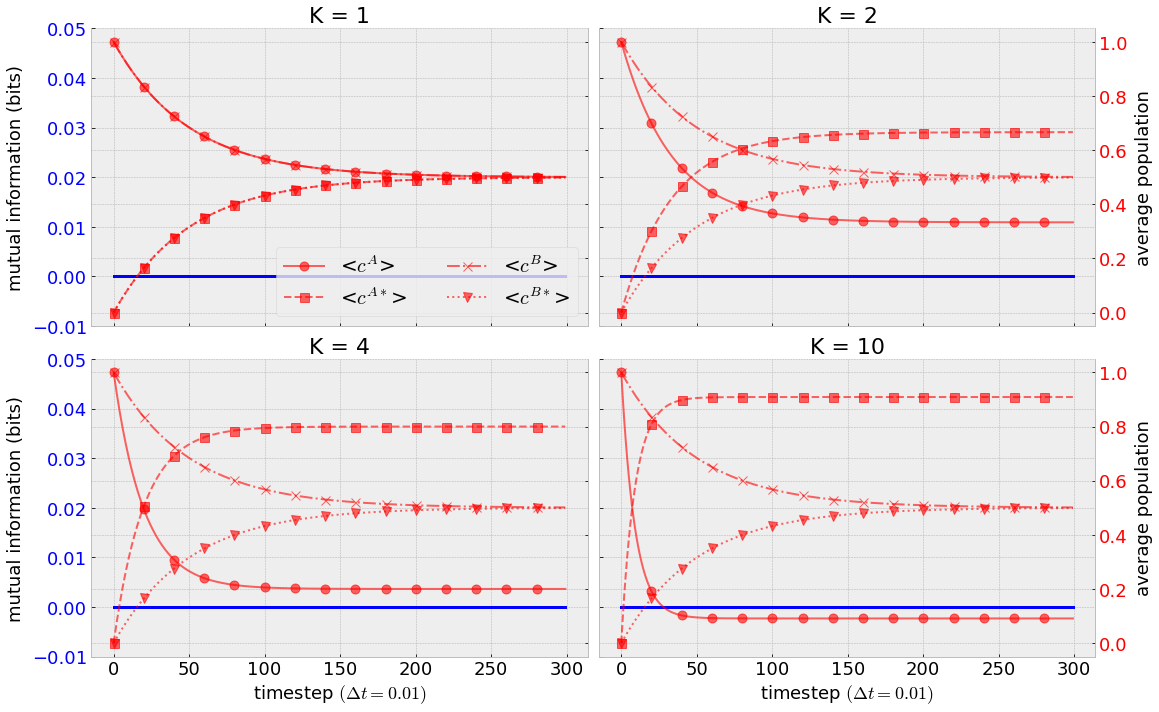

In [136]:
plot_mi_with_species(iso_switches_dict, ['A', 'A*', 'B', 'B*'], title='iso_switch')

## 2 switches that compete for substrate

In [ ]:
k1, k2, k3, k4 = 1, 1, 1, 1

G = np.array([[-(k1+k2), k2, k4],
              [    k1,  -k2,  0],
              [    k3,    0,-k4]])
dt = 0.01
Q = expm(G*dt)
start, stop = 0, 1
n_timesteps = int(np.round((stop - start) / dt))
P_t = np.empty(shape=(n_timesteps, len(G)), dtype=np.float64)
# set intial state 
P_t[0] = np.array([1,0,0])
# apply propagator n_timesteps-1 times
for ts in range(n_timesteps-1):
    P_t[ts+1] = Q.dot(P_t[ts])

In [152]:
switches_with_substrate = c3s.simulators.MasterEquation(A=1, B=1, S=1,
                                                        cfg='config_files/2_switches_with_substrate.yml')
switches_with_substrate_dict = {}

rank 0 working on generator matrix.:   0%|          | 0/3 [00:00<?, ?it/s]

In [169]:
for rate1 in [1,2,4,10]:
    for rate2 in [1, 2, 4, 10]:
        switches_with_substrate.reset_rates()
        switches_with_substrate.update_rates(k_1=rate1, k_3=rate2)
        switches_with_substrate.run(0, 3, 0.01)
        switches_with_substrate_dict[(rate1, rate2)] = [
            switches_with_substrate.calculate_average_population('A'),
            switches_with_substrate.calculate_average_population('AS'),
            switches_with_substrate.calculate_average_population('B'),
            switches_with_substrate.calculate_average_population('BS'),
            switches_with_substrate.calculate_mutual_information(['A', 'AS'], ['B', 'BS'], base=2)]

rank 0 running.:   0%|          | 0/299 [00:00<?, ?it/s]

rank 0 calculating mutual information.:   0%|          | 0/300 [00:00<?, ?it/s]

rank 0 running.:   0%|          | 0/299 [00:00<?, ?it/s]

rank 0 calculating mutual information.:   0%|          | 0/300 [00:00<?, ?it/s]

rank 0 running.:   0%|          | 0/299 [00:00<?, ?it/s]

rank 0 calculating mutual information.:   0%|          | 0/300 [00:00<?, ?it/s]

rank 0 running.:   0%|          | 0/299 [00:00<?, ?it/s]

rank 0 calculating mutual information.:   0%|          | 0/300 [00:00<?, ?it/s]

rank 0 running.:   0%|          | 0/299 [00:00<?, ?it/s]

rank 0 calculating mutual information.:   0%|          | 0/300 [00:00<?, ?it/s]

rank 0 running.:   0%|          | 0/299 [00:00<?, ?it/s]

rank 0 calculating mutual information.:   0%|          | 0/300 [00:00<?, ?it/s]

rank 0 running.:   0%|          | 0/299 [00:00<?, ?it/s]

rank 0 calculating mutual information.:   0%|          | 0/300 [00:00<?, ?it/s]

rank 0 running.:   0%|          | 0/299 [00:00<?, ?it/s]

rank 0 calculating mutual information.:   0%|          | 0/300 [00:00<?, ?it/s]

rank 0 running.:   0%|          | 0/299 [00:00<?, ?it/s]

rank 0 calculating mutual information.:   0%|          | 0/300 [00:00<?, ?it/s]

rank 0 running.:   0%|          | 0/299 [00:00<?, ?it/s]

rank 0 calculating mutual information.:   0%|          | 0/300 [00:00<?, ?it/s]

rank 0 running.:   0%|          | 0/299 [00:00<?, ?it/s]

rank 0 calculating mutual information.:   0%|          | 0/300 [00:00<?, ?it/s]

rank 0 running.:   0%|          | 0/299 [00:00<?, ?it/s]

rank 0 calculating mutual information.:   0%|          | 0/300 [00:00<?, ?it/s]

rank 0 running.:   0%|          | 0/299 [00:00<?, ?it/s]

rank 0 calculating mutual information.:   0%|          | 0/300 [00:00<?, ?it/s]

rank 0 running.:   0%|          | 0/299 [00:00<?, ?it/s]

rank 0 calculating mutual information.:   0%|          | 0/300 [00:00<?, ?it/s]

rank 0 running.:   0%|          | 0/299 [00:00<?, ?it/s]

rank 0 calculating mutual information.:   0%|          | 0/300 [00:00<?, ?it/s]

rank 0 running.:   0%|          | 0/299 [00:00<?, ?it/s]

rank 0 calculating mutual information.:   0%|          | 0/300 [00:00<?, ?it/s]

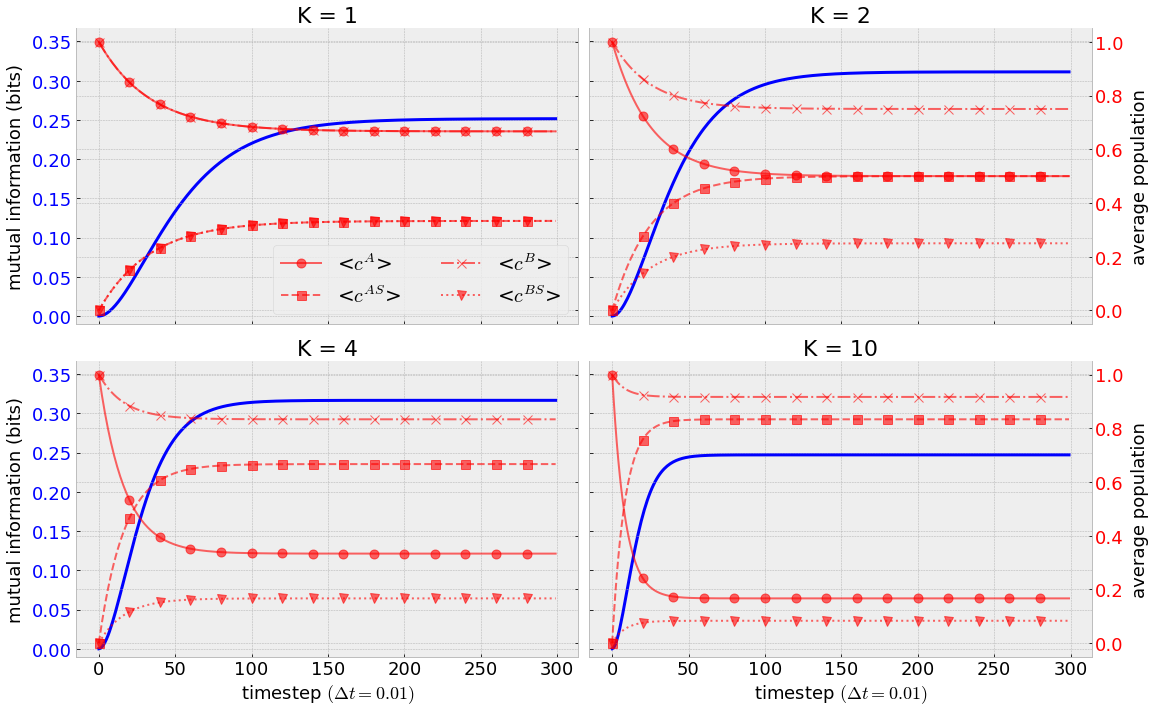

In [159]:
plot_mi_with_species(switches_with_substrate_dict, ['A', 'AS', 'B', 'BS'])

## Enzyme with no allostery

In [137]:
enzyme_no_allostery = c3s.simulators.MasterEquation(A=1, B=1, S=1, cfg='config_files/enzyme_no_allostery.yml')

rank 0 working on generator matrix.:   0%|          | 0/5 [00:00<?, ?it/s]

In [145]:
enzyme_no_allostery.run(0, 3, 0.01)
mi = enzyme_no_allostery.calculate_mutual_information(['A', 'AS'], ['B', 'BP'])
mi_dict = {1: [enzyme_no_allostery.calculate_average_population('A'),
               enzyme_no_allostery.calculate_average_population('AS'),
               enzyme_no_allostery.calculate_average_population('B'),
               enzyme_no_allostery.calculate_average_population('BP'),
               enzyme_no_allostery.calculate_mutual_information(['A', 'AS'], ['B', 'BP'], base=2)]}

rank 0 running.:   0%|          | 0/299 [00:00<?, ?it/s]

rank 0 calculating mutual information.:   0%|          | 0/300 [00:00<?, ?it/s]

rank 0 calculating mutual information.:   0%|          | 0/300 [00:00<?, ?it/s]

KeyError: 2

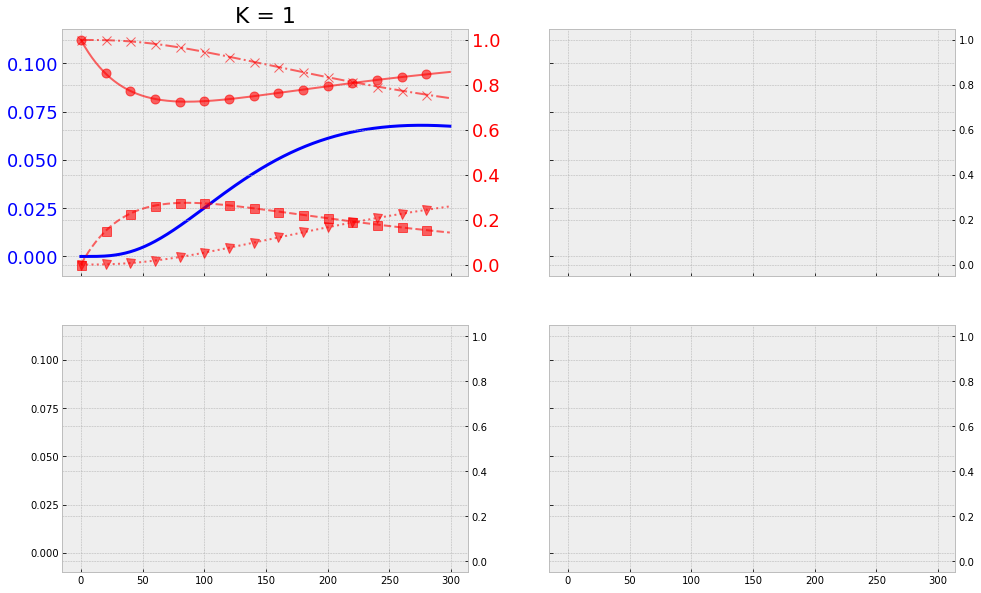

In [146]:
plot_mi_with_species(mi_dict, ['A', 'AS', 'B', 'BP'])